<a href="https://colab.research.google.com/github/mariamarseliameres/202055202015-Maria/blob/master/DL%20-%20Klasifikasi%20Jenis%20Manggis%20-%20M6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')  

Mounted at /content/gdrive


In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mariameres","key":"3e435a7d8b66b11e267bcb789e56b611"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 May 10 13:10 kaggle.json


In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mariameres/deep-learning-klasifikasi-jenis-buah-manggis

 71% 5.00M/7.04M [00:00<00:00, 24.0MB/s]
100% 7.04M/7.04M [00:00<00:00, 31.4MB/s]


In [7]:
!unzip deep-learning-klasifikasi-jenis-buah-manggis.zip

Archive:  deep-learning-klasifikasi-jenis-buah-manggis.zip
  inflating: Manggis/manggis busuk/1.jpg  
  inflating: Manggis/manggis busuk/10.jpg  
  inflating: Manggis/manggis busuk/100.jpg  
  inflating: Manggis/manggis busuk/11.jpg  
  inflating: Manggis/manggis busuk/12.jpg  
  inflating: Manggis/manggis busuk/13.jpg  
  inflating: Manggis/manggis busuk/14.jpg  
  inflating: Manggis/manggis busuk/15.jpg  
  inflating: Manggis/manggis busuk/16.jpg  
  inflating: Manggis/manggis busuk/17.jpg  
  inflating: Manggis/manggis busuk/18.jpg  
  inflating: Manggis/manggis busuk/19.jpg  
  inflating: Manggis/manggis busuk/2.jpg  
  inflating: Manggis/manggis busuk/20.jpg  
  inflating: Manggis/manggis busuk/21.jpg  
  inflating: Manggis/manggis busuk/22.jpg  
  inflating: Manggis/manggis busuk/23.jpg  
  inflating: Manggis/manggis busuk/24.jpg  
  inflating: Manggis/manggis busuk/25.jpg  
  inflating: Manggis/manggis busuk/26.jpg  
  inflating: Manggis/manggis busuk/27.jpg  
  inflating: Mangg

In [8]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [9]:
dataset_path = Path(r'/content/Manggis')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [10]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/Manggis/manggis busuk/25.jpg,manggis busuk
1,/content/Manggis/manggis busuk/97.jpg,manggis busuk
2,/content/Manggis/manggis busuk/83.jpg,manggis busuk
3,/content/Manggis/manggis busuk/87.jpg,manggis busuk
4,/content/Manggis/manggis busuk/95.jpg,manggis busuk


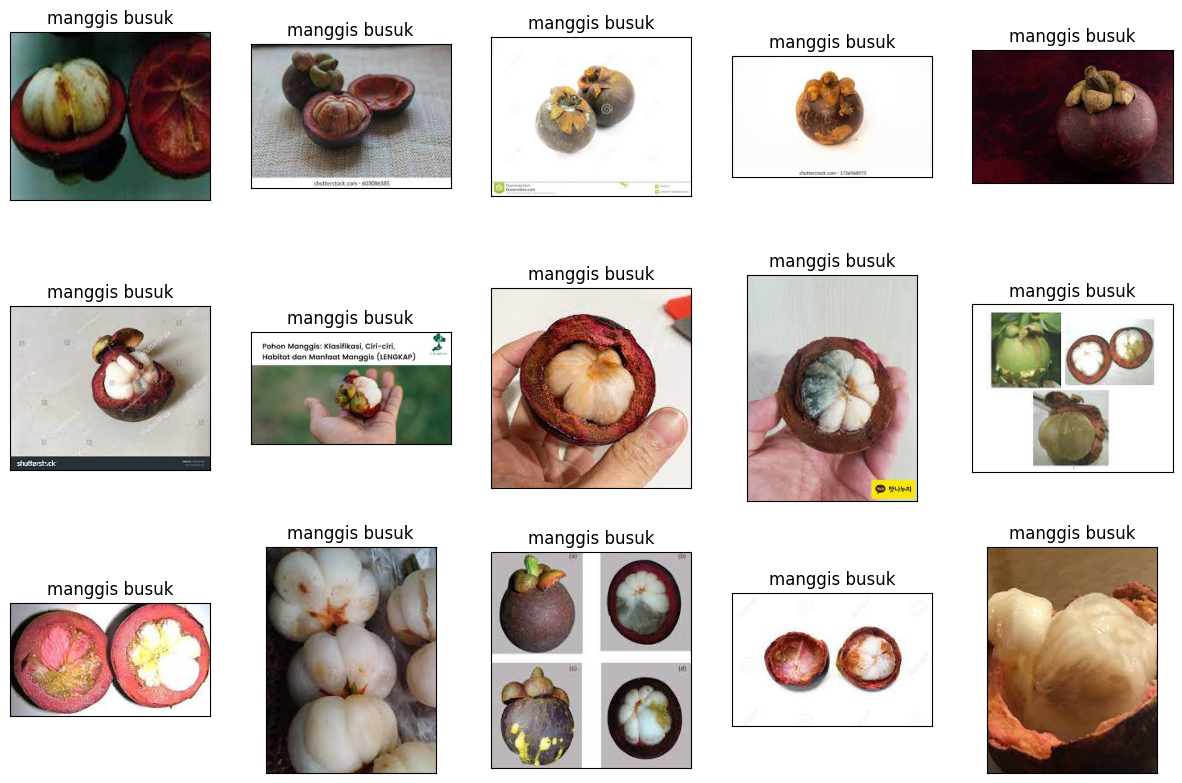

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [12]:
df.label.value_counts()

manggis busuk    100
manggis muda     100
manggis masak     97
Name: label, dtype: int64

In [13]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

manggis busuk    100
manggis muda     100
manggis masak     97
Name: label, dtype: int64

In [14]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [15]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (165, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [16]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 165 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [17]:
input_shape = (200, 200, 3)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [36]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=5, callbacks=callback)

Epoch 1/5
6/6 [==============================] - 28s 4s/step - loss: 0.9605 - accuracy: 0.5273 - val_loss: 0.7245 - val_accuracy: 0.6429
Epoch 2/5
6/6 [==============================] - 26s 4s/step - loss: 0.7552 - accuracy: 0.6364 - val_loss: 0.7448 - val_accuracy: 0.7381
Epoch 3/5
6/6 [==============================] - 26s 4s/step - loss: 0.7640 - accuracy: 0.6485 - val_loss: 0.6801 - val_accuracy: 0.7857
Epoch 4/5
6/6 [==============================] - 26s 4s/step - loss: 0.7369 - accuracy: 0.6121 - val_loss: 0.6486 - val_accuracy: 0.7143
Epoch 5/5
6/6 [==============================] - 26s 5s/step - loss: 0.6490 - accuracy: 0.6848 - val_loss: 0.7332 - val_accuracy: 0.7857


In [23]:
model.save('model-1.h5')

In [24]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

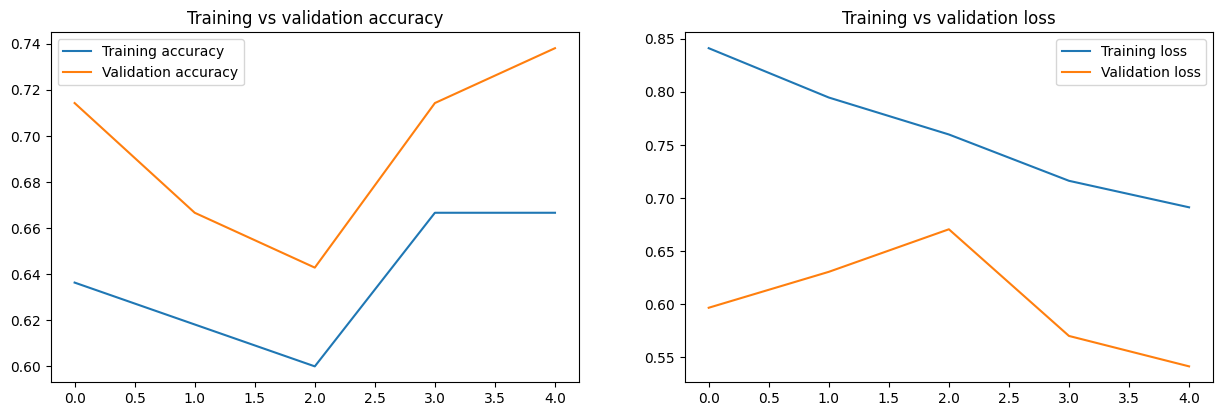

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [26]:
pred = model.predict(test)

3/3 [==============================] - 7s 2s/step


In [27]:
pred = np.argmax(pred, axis=1)

In [28]:
labels = train.class_indices

In [29]:
labels

{'manggis busuk': 0, 'manggis masak': 1, 'manggis muda': 2}

In [30]:
labels = dict((v,k) for k, v in labels.items())

In [31]:
labels

{0: 'manggis busuk', 1: 'manggis masak', 2: 'manggis muda'}

In [32]:
y_pred = [labels[k] for k in pred]

In [33]:
print(classification_report(x_test.label, y_pred))

               precision    recall  f1-score   support

manggis busuk       0.70      0.91      0.79        34
manggis masak       0.71      0.48      0.57        25
 manggis muda       1.00      0.94      0.97        31

     accuracy                           0.80        90
    macro avg       0.80      0.78      0.78        90
 weighted avg       0.81      0.80      0.79        90



In [34]:
print(confusion_matrix(x_test.label, y_pred))

[[31  3  0]
 [13 12  0]
 [ 0  2 29]]


In [35]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 4s 910ms/step - loss: 0.5849 - accuracy: 0.7333
